In [77]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [78]:
pickle_off = open ("data/return_1m.pkl", "rb")
return_1m = pickle.load(pickle_off)
return_1m

,us_unemployment_1m_return,US_CPI_1m_return,FED_RATE_1m_return,india_cpi_1m_return,Nifty_50_1m_return,Dow_Jons_1m_return,NASDAQ_1m_return,BRENT_1m_return,BOND_10Y_1m_return,Gold_1m_return,Inr_Usd_1m_return,Dollar_Index_1m_return,sgx_1m_return,indiavix_1m_return
01-01-08,-1.00,-1.93,0.27,0.00,-1.740273,-1.907285,-2.148511,-0.389611,-49.147757,-1.427281,0.064940,-0.790888,-1.667327,-2.658513
01-02-08,0.00,-2.22,2.44,0.00,-1.364678,-0.573348,-17.204443,-0.536691,-2.640800,-1.066902,0.853322,-0.849704,-1.514928,-1.069338
01-03-08,-3.04,-0.81,-0.49,-57.30,-0.622559,-2.378893,-5.037357,0.907588,-2.098772,-0.377219,0.242068,3.969377,-0.500891,2.568136
01-04-08,-1.48,-0.00,0.02,-1.02,-0.916326,-0.657176,-0.308142,-1.017062,3.456409,-2.192712,1.965266,-1.727833,-0.910453,-0.403968
01-05-08,-5.08,-6.42,0.04,-0.01,0.490591,-0.665432,0.354165,0.301586,0.212544,-0.967394,-1.428208,0.611462,0.800141,-1.184897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01-10-22,-2.06,6.53,1.06,-1.57,-3.249616,-1.418500,-5.992134,-1.228532,-0.233398,-0.589414,-14.559356,-2.117325,-4.329774,-1.998233
01-11-22,-1.47,0.47,0.12,0.78,-2.322544,-0.514827,0.170210,-1.664327,-0.511814,0.029025,0.270736,-1.808025,-2.044104,1.517237
01-12-22,0.03,0.13,-0.63,-1.15,-1.035931,-0.737765,-2.483332,0.743761,-0.569696,-0.808562,-1.461215,-0.787486,-1.078462,-1.367788
01-01-23,0.03,-0.93,-0.34,5.92,-6.263978,-1.718143,-1.998147,0.033959,-1.335379,3.679154,-2.045545,-0.080379,-1.001341,-1.132070


In [79]:
# Add lagged returns as features
return_1m['Nifty_50_1m_return'] = return_1m['Nifty_50_1m_return'].shift(1)
return_1m['Dow_Jons_1m_return_lag1'] = return_1m['Dow_Jons_1m_return'].shift(1)
return_1m = return_1m.dropna()
return_1m['return_squared'] = return_1m['Nifty_50_1m_return'] ** 2
return_1m['return_lag_interaction'] = return_1m['Nifty_50_1m_return'] * return_1m['Dow_Jons_1m_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1m['Nifty_50_1m_return'].quantile(0.25)
q3 = return_1m['Nifty_50_1m_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1m = return_1m[(return_1m['Nifty_50_1m_return'] >= lower_bound) & (return_1m['Nifty_50_1m_return'] <= upper_bound)]
np.random.seed(42)

C:\Users\Harsh\AppData\Local\Temp\ipykernel_12528\3370226014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_1m['return_squared'] = return_1m['Nifty_50_1m_return'] ** 2
C:\Users\Harsh\AppData\Local\Temp\ipykernel_12528\3370226014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_1m['return_lag_interaction'] = return_1m['Nifty_50_1m_return'] * return_1m['Dow_Jons_1m_return_lag1']


In [80]:
# Display the cleaned data
print("Cleaned data:")
print(return_1m.head())

Cleaned data:
          us_unemployment_1m_return  US_CPI_1m_return  FED_RATE_1m_return  \
01-02-08                       0.00             -2.22                2.44   
01-03-08                      -3.04             -0.81               -0.49   
01-04-08                      -1.48             -0.00                0.02   
01-05-08                      -5.08             -6.42                0.04   
01-06-08                      -0.54              2.34               -1.08   

          india_cpi_1m_return  Nifty_50_1m_return  Dow_Jons_1m_return  \
01-02-08                 0.00           -1.740273           -0.573348   
01-03-08               -57.30           -1.364678           -2.378893   
01-04-08                -1.02           -0.622559           -0.657176   
01-05-08                -0.01           -0.916326           -0.665432   
01-06-08                -0.01            0.490591            0.184837   

          NASDAQ_1m_return  BRENT_1m_return  BOND_10Y_1m_return  \
01-02-08        -

In [81]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1m.describe())

Statistics of the cleaned data:
       us_unemployment_1m_return  US_CPI_1m_return  FED_RATE_1m_return  \
count                 134.000000        134.000000          134.000000   
mean                   -0.796866         -0.886567           -0.487836   
std                     1.062919          3.944034            4.147834   
min                    -5.080000        -26.050000          -31.410000   
25%                    -1.477500         -1.522500           -1.000000   
50%                    -0.655000         -0.670000           -0.425000   
75%                     0.000000          0.277500            0.000000   
max                     1.430000         11.890000           18.100000   

       india_cpi_1m_return  Nifty_50_1m_return  Dow_Jons_1m_return  \
count           134.000000          134.000000          134.000000   
mean             -1.927164           -0.897240           -3.125410   
std              13.999371            1.982149           27.640582   
min             -90.8

In [82]:
# Correlation analysis
corr_matrix_1m = return_1m.corr()
nifty_corr_1m = pd.DataFrame(return_1m.corr()['Nifty_50_1m_return'].sort_values())
nifty_corr_1m

,Nifty_50_1m_return
return_squared,-0.532943
Dollar_Index_1m_return,-0.206182
return_lag_interaction,-0.148028
FED_RATE_1m_return,-0.115740
BRENT_1m_return,-0.063922
us_unemployment_1m_return,-0.045657
indiavix_1m_return,-0.030024
Inr_Usd_1m_return,-0.014322
india_cpi_1m_return,0.006917
NASDAQ_1m_return,0.046703


<Axes: >

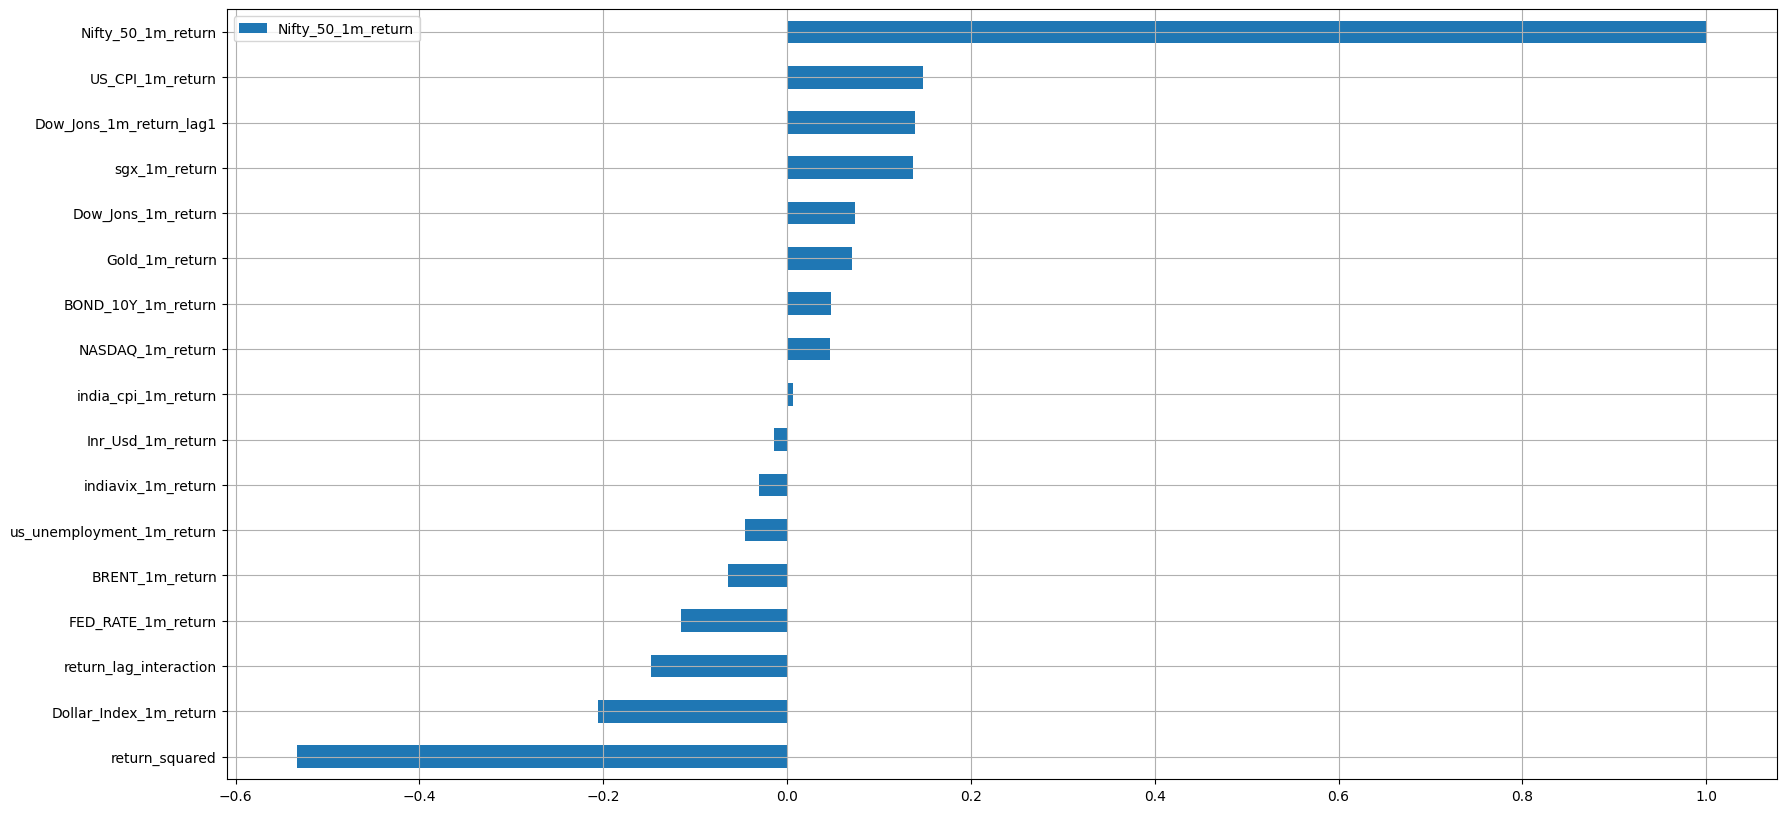

In [83]:
filter = np.abs(nifty_corr_1m)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1m[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [84]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1m.drop(columns='Nifty_50_1m_return')
y = return_1m['Nifty_50_1m_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['us_unemployment_1m_return', 'US_CPI_1m_return', 'FED_RATE_1m_return',
       'india_cpi_1m_return', 'Dow_Jons_1m_return', 'NASDAQ_1m_return',
       'BRENT_1m_return', 'BOND_10Y_1m_return', 'Gold_1m_return',
       'Inr_Usd_1m_return', 'Dollar_Index_1m_return', 'sgx_1m_return',
       'indiavix_1m_return', 'Dow_Jons_1m_return_lag1', 'return_squared',
       'return_lag_interaction'],
      dtype='object')


In [85]:
# Feature Scaling
scaler = StandardScaler()
X = return_1m.drop(columns='Nifty_50_1m_return')
y = return_1m['Nifty_50_1m_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[-1.08894552  0.0322112  -0.0610223   0.69169994 -0.00558267 -0.07761355
  -2.18688403 -1.04165005 -0.13630517  0.30602826  0.42028832 -0.06581328
   0.83803217  0.09353692 -0.61007114 -0.08318899]
 [-1.19282241  1.88750824  0.37456749  0.02560861  0.0619855  -0.46183699
  -0.1289338   0.23620628  0.00580422 -1.61169823 -0.07602922 -0.46384239
  -0.25574063 -0.0124489  -0.39794061 -0.04820351]
 [-0.63566455  0.34524486  0.14709282  0.19410319  0.09480188  0.10284417
  -0.25818436  0.12682673  0.08325342  0.1940911  -0.00254475 -0.14773636
   0.55347162  0.05520775  0.80069373 -0.04640299]
 [ 0.78083849  0.25871523 -0.03440293  0.05572253  0.08670601 -0.14031087
   0.45601931  0.1040873  -0.02164029 -0.01680025  0.23991883 -0.01418897
  -0.11062101  0.08806711  0.09429633 -0.07475218]
 [ 0.78083849 -0.01105361  0.03577543  0.56264027  0.05110413 -0.09585138
   0.24550235 -0.19672141  0.54037068 -0.08795127  0.40791605 -0.00352321
  -0.05636205  0.07996064 -0.49658737 -0.07833486]]
01-0

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [86]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [87]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [88]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [89]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [90]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.6197
R2: 0.8502

For RFR:
MSE: 1.0497
R2: 0.7463

For ETR:
MSE: 2.5157
R2: 0.3920

For GBR:
MSE: 1.1343
R2: 0.7259

For XGBR:
MSE: 0.6555
R2: 0.8416



In [91]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is DTR with an MSE of 0.6197.


DecisionTreeRegressor(max_depth=5)

The best model is DTR with an MSE of 0.6197.

In [92]:
y_pred = rfr.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
01-06-22,-5.749008,-4.700883
01-06-15,-2.040751,-1.815640
01-08-19,-1.145199,-1.108139
01-12-09,-1.292779,-0.790993
01-10-12,-2.278419,-0.109761
01-09-14,-3.659870,-2.857782
01-03-09,-3.588434,-3.022101
01-05-20,-0.489060,-0.422221
01-03-19,1.314895,1.218492
01-04-19,-0.481438,-0.385039


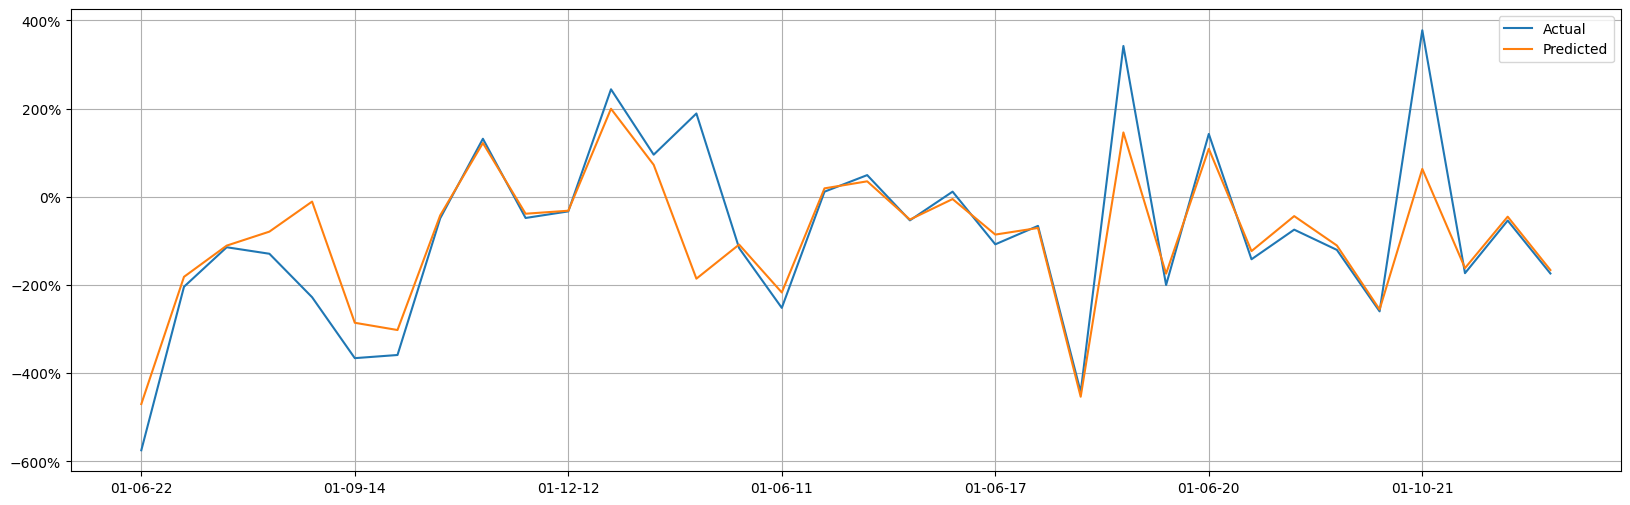

In [93]:
ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_12528\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_50_1m_return', ylabel='Density'>

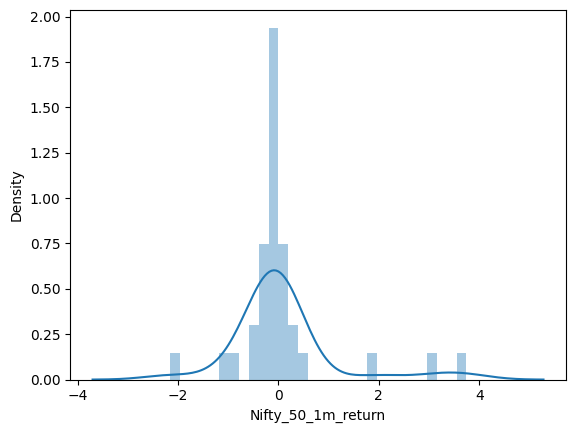

In [94]:
sns.distplot(y_test-y_pred)

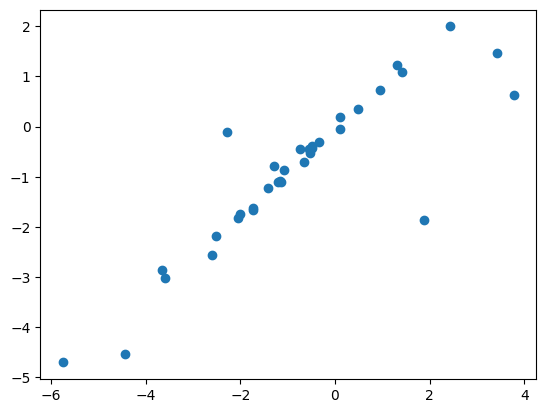

In [95]:
plt.scatter(y_test,y_pred)